<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.859 - Visualización de Datos</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencias de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

## PEC 2: Estudio de técnicas de visualización de datos

**Autor:** Fernando José Cofiño Gavito

In [1]:
# Instalar dependencias
#!pip install pygal
#!pip install geopandas
#!pip install networkx
#!pip install geopandas matplotlib cartopy

In [2]:
# Importar librerías
import plotly.express as px
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
from io import StringIO
from matplotlib.patches import Arc
import geopandas as gpd
import numpy as np
import plotly.graph_objects as go
from shapely.affinity import scale

## 1. Cartogram

In [3]:
# Cargar el archivo de límites de países del mundo
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Ajustar el factor de escala con un mínimo para países pequeños
factor_ajuste = 0.1  # Factor base para los países con menor población
world['scale'] = np.maximum(factor_ajuste, (np.sqrt(world['POP_EST']) / np.sqrt(world['POP_EST'].max())))

# Escalar cada país en relación a su centroide original para que permanezca en su posición central
world['geometry'] = world.apply(
    lambda row: scale(row.geometry, row['scale'], row['scale'], origin=row.geometry.centroid), axis=1
)

# Convertir geometría a formato geojson para usar en Plotly
world = world.to_crs(epsg=4326)  # Asegurar el sistema de coordenadas adecuado
world_json = world.__geo_interface__  # Convertir el GeoDataFrame a GeoJSON

# Crear el gráfico de mapa estático con hover
fig = go.Figure(go.Choropleth(
    geojson=world_json,
    locations=world.index,
    z=world['POP_EST'],
    colorscale="OrRd",
    marker_line_width=1,  # Borde visible
    marker_line_color="black",  # Color de los bordes
    text=world['NAME'],  # Etiquetas con el nombre de cada país
    hoverinfo="text+z"  # Mostrar nombre y población en el hover
))

# Configurar layout para mostrar el mapa en escala real
fig.update_geos(
    projection_type="natural earth",  # Proyección que respeta la forma y el tamaño real
    projection_scale=1,  # Escala de proyección en escala real
    showcountries=True,  # Mostrar bordes de los países
    countrycolor="grey",  # Color de los bordes de los países
    showcoastlines=True,  # Mostrar costas
    coastlinecolor="grey",
    showland=True,
    landcolor="lightskyblue",
    fitbounds="locations",  # Ajustar el mapa para incluir todos los países,
    lataxis_showgrid=True,
    lonaxis_showgrid=True
)

fig.update_layout(
    title={"text": "Cartograma: Países Escalados Según su Población"},
    margin={"r":0, "t":50, "l":0, "b":0}
)

# Mostrar el gráfico
fig.show()

## 2. Arc Diagram

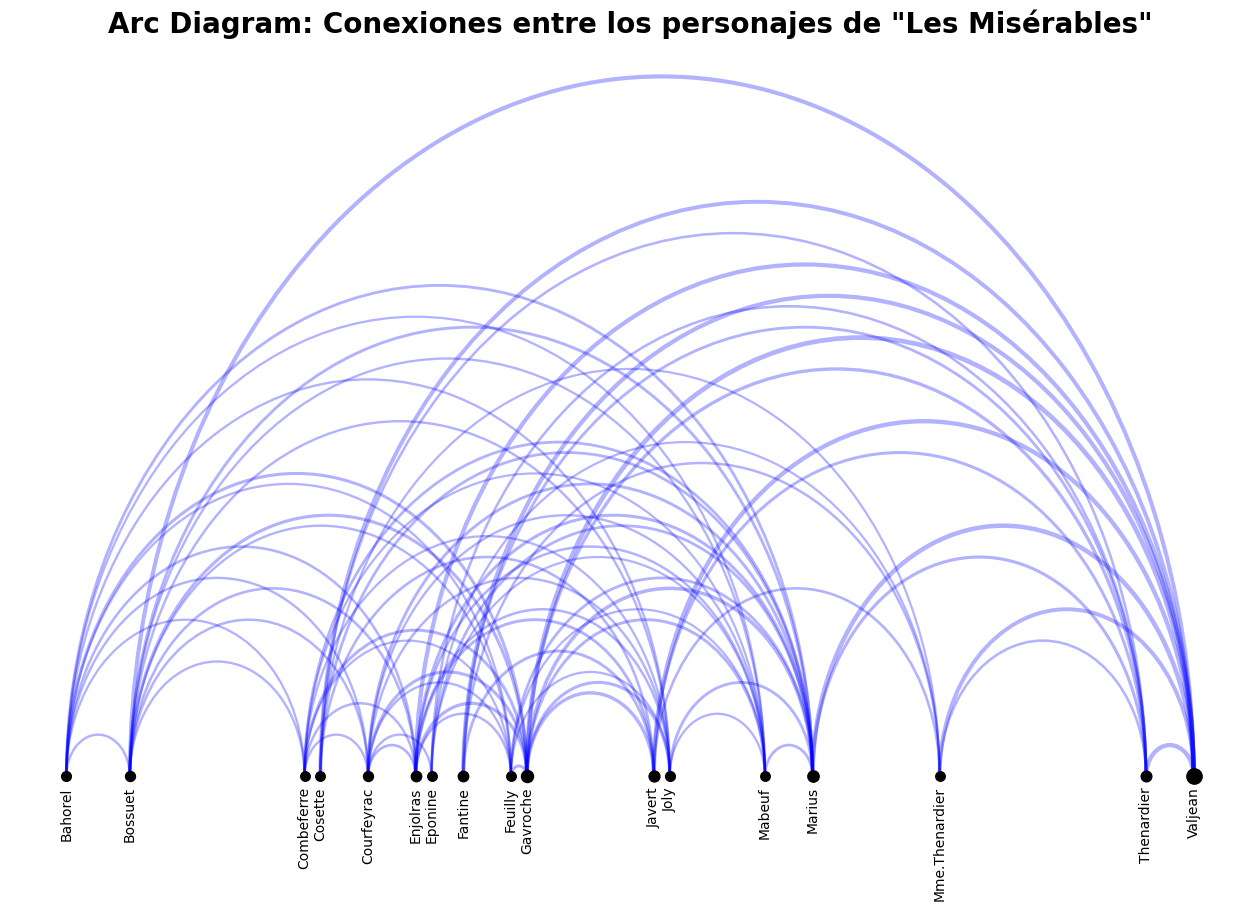

In [4]:
# Descargar el dataset de las conexiones de "Les Misérables"
url = "https://github.com/graphistry/pygraphistry/blob/52ea49afbea55291c41962f79a90d74d76c721b9/demos/data/lesmiserables.csv?raw=true"
response = requests.get(url)

# Cargar el contenido en un DataFrame de pandas
data = StringIO(response.text)
df = pd.read_csv(data)

# Crear el grafo utilizando NetworkX
graph = nx.from_pandas_edgelist(df, source='source', target='target')

# Ordenar los nodos de forma consecutiva para el diagrama de arcos
nodes_sorted = sorted(graph.nodes())
node_indices = {node: idx for idx, node in enumerate(nodes_sorted)}

# Filtrar nodos con alto grado de conexión para mostrar sus etiquetas y puntos
high_degree_nodes = [node for node, degree in dict(graph.degree()).items() if degree > 10]

# Definir la posición de cada nodo en una sola línea (diagrama de arcos)
positions = {node: (idx, 0) for node, idx in node_indices.items()}

# Graficar el diagrama de arcos
plt.figure(figsize=(16, 10))
ax = plt.gca()
ax.set_facecolor('white')

# Dibujar solo los nodos de alto grado
node_sizes = [300 * (graph.degree(node) / max(dict(graph.degree()).values())) for node in high_degree_nodes]
for node in high_degree_nodes:
    idx = node_indices[node]
    plt.plot([idx], [0], 'o', color='black', markersize=5 + node_sizes[high_degree_nodes.index(node)] / 50)
    plt.text(idx, -0.25, node, fontsize=10, ha='center', va='top', rotation=90)  # Etiquetas debajo de los nodos de alto grado

# Dibujar los arcos con transparencia y diferente grosor basado en el grado de conexión usando Arc
for edge in graph.edges():
    node1, node2 = edge
    if node1 in high_degree_nodes and node2 in high_degree_nodes:  # Solo dibujar arcos entre nodos de alto grado
        x1, x2 = node_indices[node1], node_indices[node2]
        if x1 != x2:
            radius = abs(x2 - x1) / 2
            center = (x1 + x2) / 2
            edge_weight = graph.degree(node1) + graph.degree(node2)
            
            # Usar Arc en lugar de Circle
            arc = Arc((center, 0), width=2 * radius, height=radius, angle=0, theta1=0, theta2=180,
                      edgecolor='blue', linestyle='-', linewidth=0.5 + edge_weight / 20, alpha=0.3)
            ax.add_patch(arc)

# Quitar los ejes para una mejor visualización
plt.axis('off')

# Título del gráfico
plt.title("Arc Diagram: Conexiones entre los personajes de \"Les Misérables\"", fontsize=20, weight='bold')

# Mostrar el diagrama de arcos
plt.show()

## 3. Connected Scatterplots

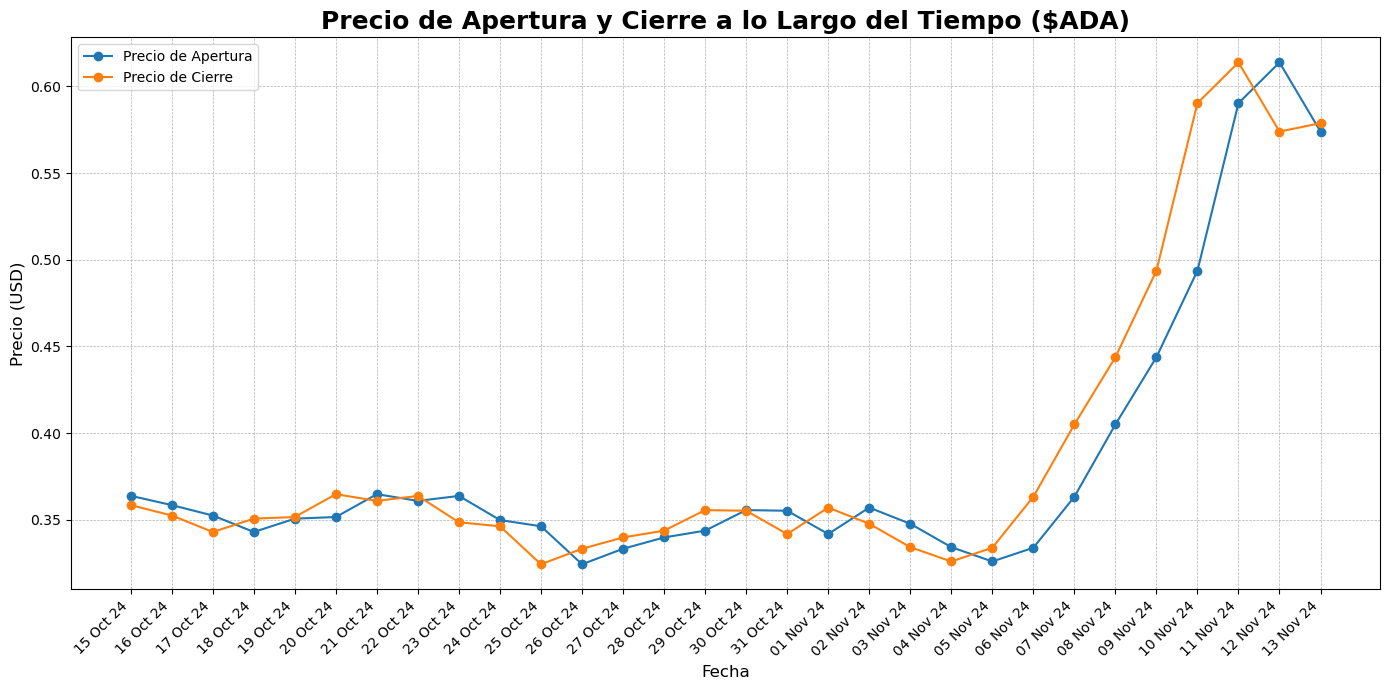

In [5]:
# Cargar los datos
df = pd.read_csv("cardano.csv", delimiter=";")

# Convertir timestamp a formato de fecha y limpiar datos, removiendo zona horaria
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce').dt.tz_localize(None)
df = df.sort_values(by='timestamp')  # Ordenar por fecha para secuencia temporal

# Tamaño del gráfico
plt.figure(figsize=(14, 7))

# Graficar precios de apertura y cierre a lo largo del tiempo
plt.plot(df['timestamp'], df['open'], label='Precio de Apertura', linestyle='-', marker='o')
plt.plot(df['timestamp'], df['close'], label='Precio de Cierre', linestyle='-', marker='o')

# Título y etiquetas de los ejes
plt.title("Precio de Apertura y Cierre a lo Largo del Tiempo ($ADA)", fontsize=18, weight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio (USD)", fontsize=12)

# Configuración para mostrar todos los días en el eje x
plt.xticks(df['timestamp'], df['timestamp'].dt.strftime('%d %b %y'), rotation=45, ha='right')

# Agregar leyenda
plt.legend()

# Agregar cuadrícula
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Cuadrícula con líneas punteadas

plt.tight_layout() 
plt.show()

## 4. Referencias datasets utilizados

* [1] Natural Earth   » 1:110m Cultural Vectors - Free vector and raster map data at 1:10m, 1:50m, and 1:110m scales. (s. f.). https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
* [2] Graphistry. (s. f.). pygraphistry/demos/data/lesmiserables.csv at 52ea49afbea55291c41962f79a90d74d76c721b9 · graphistry/pygraphistry. GitHub. https://github.com/graphistry/pygraphistry/blob/52ea49afbea55291c41962f79a90d74d76c721b9/demos/data/lesmiserables.csv?raw=true
* [3] Cardano price today, ADA to USD live price, marketcap and chart | CoinMarketCap. (s. f.). CoinMarketCap. https://coinmarketcap.com/currencies/cardano/

## 5. Otras referencias

* [1] Holtz, Y. (s. f.). Connected Scatterplot. The Python Graph Gallery. https://python-graph-gallery.com/connected-scatter-plot/
* [2] Scatter Plots in Python. (s. f.) Plotly. https://plotly.com/python/line-and-scatter/
* [3] Holtz, Y. (s. f.). Cartogram. The Python Graph Gallery. https://python-graph-gallery.com/cartogram/
* [4] cartogram. (2024, 15 julio). PyPI. https://pypi.org/project/cartogram/
* [5] Mattdzugan. (s. f.). GitHub - mattdzugan/World-Population-Cartogram: This repository contains a set of data able to reproduce Max Roser’s beautiful masterpiece for «Our World in Data» -- The World Population Cartogram. GitHub. https://github.com/mattdzugan/World-Population-Cartogram
* [6] Aomader. (s. f.). GitHub - aomader/arc-diagrams: A Python implementation of arc diagrams as specified by Wattenberg. GitHub. https://github.com/aomader/arc-diagrams
* [7] J-Brent. (s. f.). GitHub - j-brent/arc-diagrams: Visualize repetitive structure encoded in a linear string of characters. GitHub. https://github.com/j-brent/arc-diagrams
* [8] Plotly Technologies Inc. (2015). Plotly Express. Plotly Technologies Inc. [Python library]. https://plotly.com/python/
* [9] McKinney, W. (2010). Data structures for statistical computing in Python. In S. van der Walt & J. Millman (Eds.), Proceedings of the 9th Python in Science Conference (pp. 51–56). https://doi.org/10.25080/Majora-92bf1922-00a
* [10] Hagberg, A., Schult, D., & Swart, P. (2008). Exploring network structure, dynamics, and function using NetworkX. In Proceedings of the 7th Python in Science Conference (pp. 11–15). https://networkx.org/
* [11] Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. *Computing in Science & Engineering, 9*(3), 90–95. https://doi.org/10.1109/MCSE.2007.55
* [12] Reitz, K., & Team, P. (2011). Requests: HTTP for Humans. [Python library]. https://docs.python-requests.org/
* [13] Python Software Foundation. (2001). StringIO. In Python Documentation. https://docs.python.org/3/library/io.html
* [14] Matplotlib Development Team. (2007). Matplotlib patches: Arc. In *Matplotlib Documentation*. https://matplotlib.org/stable/api/patches_api.html#matplotlib.patches.Arc
* [15] Jordahl, K., Perry, M., & Contributors. (2014). GeoPandas: Python tools for geographic data. [Python library]. https://geopandas.org/
* [16] Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., & Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2
* [17] Gillies, S., Tygier, S., & Contributors. (2007). Shapely: Manipulation and analysis of geometric objects. [Python library]. https://shapely.readthedocs.io/en/stable/manual.html